## Assignment 3
Priyansh Khunger

2020101056

### Q1 Face detection and association-based tracking

In [1]:
!pip install numpy
!pip install matplotlib
!pip install opencv-python
# !pip install os-sys

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

#### 1. Data Preparation

In [2]:
# function to convert video to frames
def video_to_frames(video, folder_name, duration=30):

    if os.path.exists(folder_name):
        for file_name in os.listdir(folder_name):
            string1 = ""
            string1 = str(folder_name) + "/" + str(file_name)
            os.remove(string1)
    else:
        os.makedirs(folder_name)

    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(fps* duration)
    current_frame = 0

    while(1):
        # extracting the frames
        ret, frame = video.read()
        # if frame is extracted
        if ret == True and current_frame <= frame_count:
            # writing the extracted frame
            v = str(video.get(1)).split('.')[0]
            cv2.imwrite('./'+folder_name+'/'+ v +'.jpg', frame)
            current_frame += 1
        else:
            break

    # releasing the video object
    video.release()
    # closing all the windows
    cv2.destroyAllWindows()

# Bursting into frames
input_path = './Q1_inputs/Forrest Gump (1994) - Run, Forrest, Run! Scene _ Movieclips.mp4'
input_video = cv2.VideoCapture(input_path)

output_folder_frames = './Q1_outputs/Q1_frames'
video_to_frames(input_video, output_folder_frames, duration=30)

#### 2. Face Detection

In [3]:
# performing face detection on the frames, using viola-jones 
def face_detection(input_folder_face_frames, output_folder_face_frames):

    faces_arr = []

    if os.path.exists(output_folder_face_frames):
        for file_name in os.listdir(output_folder_face_frames):
            string1 = ""
            string1 = str(output_folder_face_frames) + "/" + str(file_name)
            os.remove(string1)
    else:
        os.makedirs(output_folder_face_frames)

    # loading the face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    frame_count = 0

    file_names = [img for img in os.listdir(input_folder_face_frames) if img.endswith(".jpg")]
    file_names.sort(key=lambda x: int(x.split('.')[0]))
    
    for file_name in file_names:
        frame_path = input_folder_face_frames + '/' + file_name
        frame = cv2.imread(frame_path)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # detecting faces in the image
        faces = face_cascade.detectMultiScale(gray_frame, 1.3, 5)

        # drawing rectangle around the faces
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # writing the output image
        cv2.imwrite(output_folder_face_frames + '/' + file_name, frame)

        frame_count += 1
        print("Number of frames processed: ", frame_count, end='\r')

        if (len(faces)!= 0):
            faces_arr.append(faces)
        else:
            faces_arr.append('None')

        

    return faces_arr

output_folder_face_frames = './Q1_outputs/Q1_face_frames'
input_folder_face_frames = output_folder_frames

faces_arr = face_detection(input_folder_face_frames, output_folder_face_frames)


It took about 110 seconds to process 720 frames in initial run.

In [4]:
# To read the xml config file

def read_xml(xml_file, destination_xml_file):
    with open(xml_file, 'r') as file:
        data = file.read()
    
    # writing the data into a text file
    with open(destination_xml_file, 'w') as file:
        file.write(data)

destination_xml_file = './Q1_outputs/Q1_xml_config.txt'
read_xml(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml' , destination_xml_file)

To reduce the time of the algorithm, we can reduce the number of weak classifiers or the number of features

#### 3. Face Detection Visualisation

In [5]:
# function to generate video from frames
def images_to_video(image_folder, video_name, fps):
    
    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    images.sort(key=lambda x: int(x.split('.')[0]))

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

images_to_video(output_folder_face_frames, './Q1_outputs/Q1_output.mp4', 24)

[Link to the video](
https://iiitaphyd-my.sharepoint.com/:v:/g/personal/amey_choudhary_research_iiit_ac_in/ETcl1AisxK9NlKttbbsAnRUBWbETTepcn_NSrkmIwBKKsQ?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=9wTlBf )

Places where this fails:
1. Only faces which are frontal can be detected. Side or back view of face cannot be detected.
2. It doesn't work when the faces are in background i.e. multiscale may not always work
3. Multiple faces (at the same scale too) are not detected

#### 4. Association-based tracking

In [6]:
# getting faces in each frame
frames_with_faces = {}
for i in range(len(faces_arr)):
    face = faces_arr[i]
    if isinstance(face, str):
        continue
    else:
        num_face_detected = len(face)
        frames_with_faces[i]= []
        for j in range(num_face_detected):
            x = int(face[j][0])
            y = int(face[j][1])
            w = int(face[j][2])
            h = int(face[j][3])
            frames_with_faces[i].append([x,y,w,h])


In [11]:
# function to calculate IoU
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    boxA_area = (boxA[2] + 1) * (boxA[3] + 1)
    boxB_area = (boxB[2] + 1) * (boxB[3] + 1)

    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    union_area = boxA_area + boxB_area - intersection_area

    iou = intersection_area / float(union_area)

    return iou

In [26]:
# association face tracking
tracks_faces = {}
max_tracks = 0

output_folder_faces_tracks = './Q1_outputs/Q1_face_tracks'
input_folder_face_frames ='./Q1_outputs/Q1_frames'

if os.path.exists(output_folder_faces_tracks):
    for file_name in os.listdir(output_folder_faces_tracks):
        string1 = ""
        string1 = str(output_folder_faces_tracks) + "/" + str(file_name)
        os.remove(string1)
else:
    os.makedirs(output_folder_faces_tracks)

frame_count = 0

file_names = [img for img in os.listdir(input_folder_face_frames) if img.endswith(".jpg")]
file_names.sort(key=lambda x: int(x.split('.')[0]))

for file_name in file_names:
    frame_path = input_folder_face_frames + '/' + file_name
    frame = cv2.imread(frame_path)
    # gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if frame_count not in frames_with_faces:
        tracks_faces={}
        frame_count = frame_count +1
        cv2.imwrite(output_folder_faces_tracks + '/' + file_name, frame)
        continue

    faces_in_frame = frames_with_faces[frame_count]
    is_tracked_ahead = {}

    for f in faces_in_frame:
        max_score = 0.5
        curr_track = 0

        for track in tracks_faces:
            iou = calculate_iou(f, tracks_faces[track])
            if iou > max_score:
                max_iou = iou
                curr_track = track
        
        if curr_track != 0:
            tracks_faces[curr_track] = f
            is_tracked_ahead[curr_track] = True # means old continued
        else:
            max_tracks = max_tracks +1
            curr_track = max_tracks
            tracks_faces[curr_track] = f
            is_tracked_ahead[curr_track] = False # means new track

        x = f[0]
        y = f[1]
        w = f[2]
        h = f[3]
            
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX 
        org = (x,y)
        fontScale = 1
        color = (255, 0, 0) 
        thickness = 2
        cv2.putText(frame, str(curr_track), org, font,fontScale, color, thickness, cv2.LINE_AA) 
    cv2.imwrite(output_folder_faces_tracks+ '/' + file_name, frame)
    

    unassigned_tracks = [track for track in tracks_faces if track not in is_tracked_ahead]
    for track in unassigned_tracks:
        del tracks_faces[track]
    

    frame_count = frame_count +1
    print(frame_count , end='\r')





In [27]:
print("Number of tracks generated: " , max_tracks)

Number of tracks generated:  50


In [28]:
images_to_video(output_folder_faces_tracks , './Q1_outputs/Q1_output_tracks.mp4', 24)

Different people don't get same tracks. The quality of tracking is good, but in cases where a frame in between didnt have face tracking, a new track is generated.


[Link to video](https://iiitaphyd-my.sharepoint.com/:v:/g/personal/amey_choudhary_research_iiit_ac_in/ERVPLwTrZ65NpMzS_evw6-0BYSJsDgt6yb8tJCabnQmZeg?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=ndIzAe)

### Q2 YOLO Object Detection


#### 1. Data Preparation
The data was downloaded and unzipped and placed into Q2_inputs

#### 2. Understanding YOLO

YOLO - You Only Look Once,  is an object detection model, introduced in 2015. It is popular for object detection, mainly due to speed it provides while detecting (allows real-time detection). It is also much more accurate than its contemporaries. The main idea behind YOLO is to do detection as regression task instead of classification task.

To explain its working in brief, YOLO divides an image into 'residual blocks', and then within each residual blocks, bounding boxes are used to detect objects. If above a certain threshold, then they are selected. The entire image is looked only once and then a single CNN is used to do this.

In comparison, R-CNN, first uses selective search to find proposals (local places in image of importance) and then uses CNN to find objects within those proposals. This search (using SVMs), followed by CNNs on each proposal, are computationally expensive.

Variants of YOLO:

1. YOLO v2: This improved by changing the architecture to Draknet19 and also adding batch normalisation, fine-grained features and higher input resolution.

2. YOLOv5: Introduced a new layer, called Focus layer, which integrated the first 3 layers of the YOLO v3. This improved the performance in terms of speed and reduced the parameters.

3. YOLOv8: It major advantage is that it is single stage detector, whereas earlier models were 2 stage detectors, thus decreasing time. It has newer architecture, called Cross Stage Partial Network and C3, a new convolutional block.

#### 3. Ultralytics

In [8]:
!pip install ultralytics

In [2]:
from ultralytics import YOLO

In [3]:
# creating a yolo-v8-nano model , with the weights from scratch
model_nano_scratch = YOLO('yolov8n-seg.yaml')

# displaying the model architecture
print(model_nano_scratch.info())

YOLOv8n-seg summary: 261 layers, 3409968 parameters, 3409952 gradients, 12.8 GFLOPs
(261, 3409968, 3409952, 12.772710400000001)


The nano model from scratch has 261 layers and 3409968 parameters.

In [4]:
# creating the yolov8 medium model
model_medium_pre = YOLO('yolov8m-seg.pt')
print(model_medium_pre.info())

YOLOv8m-seg summary: 331 layers, 27285968 parameters, 0 gradients, 110.6 GFLOPs
(331, 27285968, 0, 110.64632320000001)


Comparing the nano (scratch) model with medium model, we can see there are lesser layer and parameters in nano

#### 4. Training YOLO

Preparing the dataset

In [3]:
# list the number of images in train and validation set
def count_images_in_folder(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Count the number of files with image extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']
    image_count = sum(1 for file in files if os.path.splitext(file)[1].lower() in image_extensions)
    
    return image_count

folder_path = '/scratch/amey.choudhary/Q2_inputs/archive/images/train/'
image_count = count_images_in_folder(folder_path)
print("Number of images in the folder:", image_count)
folder_path = '/scratch/amey.choudhary/Q2_inputs/archive/images/val/'
image_count = count_images_in_folder(folder_path)
print("Number of images in the folder:", image_count)

Number of images in the folder: 400
Number of images in the folder: 50


In [4]:
# splitting the train dataset by randomly selecting 100 images
import random
import shutil

def split_images_randomly(source_folder_images, source_folder_labels, dest_folder_images,  dest_folder_labels ,num_images):
    # List all files in the source folder, ending in png
    files = [img for img in os.listdir(source_folder_images) if img.endswith(".png")]    
    # print("Number of images in the source folder:", len(files))

    # create the destination folders if they don't exist and remove content if they exist
    if not os.path.exists(dest_folder_labels):
        os.makedirs(dest_folder_labels)
    else:
        for file_name in os.listdir(dest_folder_labels):
            string1 = ""
            string1 = str(dest_folder_labels) + "/" + str(file_name)
            os.remove(string1)


    if not os.path.exists(dest_folder_images):
        os.makedirs(dest_folder_images)
    else:
        for file_name in os.listdir(dest_folder_images):
            string1 = ""
            string1 = str(dest_folder_images) + "/" + str(file_name)
            os.remove(string1)
    
    # Randomly select the required number of images
    random_files = random.sample(files, num_images)
    
    # Copy the selected images to the destination folder
    for file in random_files:
        source_path = os.path.join(source_folder_images, file)
        dest_path = os.path.join(dest_folder_images, file)
        shutil.copyfile(source_path, dest_path)
    
    # Copy the corresponding label files to the destination folder
    for file in random_files:
        file_name = os.path.splitext(file)[0]
        source_path = os.path.join(source_folder_labels, file_name + '.txt')
        dest_path = os.path.join(dest_folder_labels, file_name + '.txt')
        shutil.copyfile(source_path, dest_path)

source_folder_images = '/scratch/amey.choudhary/Q2_inputs/archive/images/train/'
source_folder_labels = '/scratch/amey.choudhary/Q2_inputs/archive/labels/train/'
dest_folder_images = '/scratch/amey.choudhary/Q2_inputs/archive100/images/train/'
dest_folder_labels = '/scratch/amey.choudhary/Q2_inputs/archive100/labels/train/'
num_images = 100

split_images_randomly(source_folder_images, source_folder_labels, dest_folder_images, dest_folder_labels, num_images)
count = count_images_in_folder(dest_folder_images)
print("Number of images in the destination folder:", count)

Number of images in the destination folder: 100


In [5]:
# copying the validation dataset
source_folder_images = '/scratch/amey.choudhary/Q2_inputs/archive/images/val/'
source_folder_labels = '/scratch/amey.choudhary/Q2_inputs/archive/labels/val/'
dest_folder_images = '/scratch/amey.choudhary/Q2_inputs/archive100/images/val/'
dest_folder_labels = '/scratch/amey.choudhary/Q2_inputs/archive100/labels/val/'
num_images = count_images_in_folder(source_folder_images)

split_images_randomly(source_folder_images, source_folder_labels, dest_folder_images, dest_folder_labels, num_images)

New dataset of length 100, along with their labels and config file has been created. Now, starting the training.

In [6]:
# for training
configs_files = ['/scratch/amey.choudhary/Q2_inputs/archive100/config.yaml' ,'/scratch/amey.choudhary/Q2_inputs/archive/config.yaml']
epochs_num = 20
image_size = 640

In [10]:
# making the models
model_nano_scratch = YOLO('yolov8n-seg.yaml')
model_nano_pre = YOLO('yolov8n-seg.pt')
model_medium_pre = YOLO('yolov8m-seg.pt')

names_t = ['nano_scratch_100_t' , 'nano_pre_100_t' , 'medium_pre_100_t']
names_v = ['nano_scratch_100_v' , 'nano_pre_100_v' , 'medium_pre_100_v']
model_ckpts = ['/runs/nan']

models_100 = []
results_100_t = []
results_100_v = []

In [17]:
# training from scratch
index_model = 0
use_checkpoint = True

result_100_t = model_nano_scratch.train(data=configs_files[0], imgsz=image_size, epochs=epochs_num, name=names_t[index_model], resume=True)
result_100_v = model_nano_scratch.val(data=configs_files[0], imgsz=image_size, name=names_v[index_model])

models_100.append(model_nano_scratch)
results_100_t.append(result_100_t)
results_100_v.append(result_100_v)

Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=/scratch/amey.choudhary/Q2_inputs/archive100/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=nano_scratch_100_t, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=None, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/train... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:01<00:00, 75.87it/s]

train: New cache created: /scratch/amey.choudhary/Q2_inputs/archive100/labels/train.cache



val: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/segment/nano_scratch_100_t/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/nano_scratch_100_t
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.71G      3.599      13.01      4.442      4.339         12        640: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         50         52    0.00224      0.635    0.00444    0.00153          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.6G      3.508      11.61      4.398      4.283         16        640: 100%|██████████| 7/7 [00:01<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         50         52    0.00225      0.635     0.0047    0.00157          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.88G      3.525      9.201      4.273      4.279          7        640: 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         50         52    0.00232      0.654    0.00529    0.00176          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.73G      3.331      7.343      4.211      4.224         11        640: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         50         52    0.00223      0.635    0.00438     0.0016          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.75G      3.402      6.095      4.091      4.197          9        640: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         50         52    0.00224      0.635    0.00467     0.0017          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.6G      3.224      5.271      4.174      4.136          6        640: 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         50         52    0.00225      0.635    0.00567    0.00211          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.75G      3.473      5.155      4.045      4.104          7        640: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

                   all         50         52     0.0023      0.654    0.00475    0.00168          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.88G      3.404      4.906      3.916      4.026         11        640: 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         50         52    0.00232      0.654    0.00496     0.0016          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.88G      3.348      4.955      4.037      3.976          9        640: 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

                   all         50         52    0.00219      0.615    0.00524    0.00173          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.86G      3.003      4.733      3.878      3.929         10        640: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         50         52    0.00212      0.596    0.00573    0.00185   6.85e-05     0.0192   3.97e-05   3.97e-06


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.89G      2.968      5.003      4.366      3.886          4        640: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         50         52    0.00214      0.596    0.00582    0.00195   6.92e-05     0.0192   4.65e-05   4.65e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.75G       2.96      5.113      4.437      3.846          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         50         52    0.00219      0.596    0.00702    0.00244   0.000141     0.0385   8.71e-05   1.25e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.89G      3.014      5.099      4.359      3.708          6        640: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

                   all         50         52    0.00222      0.596     0.0084    0.00237   0.000143     0.0385   0.000127   2.12e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.89G      3.059      4.554      4.274      3.695          5        640: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         50         52    0.00453        0.5     0.0149     0.0057   0.000523     0.0577   0.000336   7.82e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.74G      2.873      4.931      4.133      3.702          5        640: 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

                   all         50         52    0.00539      0.481     0.0358    0.00702   0.000431     0.0385   0.000225    4.5e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.62G      2.789      4.511      4.106      3.649          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

                   all         50         52    0.00535      0.481     0.0359    0.00922   0.000642     0.0577   0.000369   7.05e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.62G      2.849      4.405      4.118       3.62          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         50         52    0.00528      0.519     0.0363    0.00906   0.000782     0.0769    0.00047   6.78e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.89G      2.979      4.158      4.143      3.572          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         50         52    0.00451      0.519     0.0319    0.00791   0.000835     0.0962    0.00073   0.000229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.88G      3.004      4.412      4.193      3.587          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         50         52    0.00395      0.577     0.0226    0.00605    0.00118      0.173    0.00161   0.000457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.89G      2.911      4.241      4.125      3.602          5        640: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         50         52    0.00349      0.635     0.0175    0.00557    0.00106      0.192    0.00486   0.000811



20 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/nano_scratch_100_t/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/nano_scratch_100_t/weights/best.pt, 6.8MB

Validating runs/segment/nano_scratch_100_t/weights/best.pt...
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


                   all         50         52    0.00536      0.481     0.0286    0.00757   0.000643     0.0577   0.000369   7.06e-05
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/nano_scratch_100_t
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


                   all         50         52     0.0056      0.481     0.0363    0.00726   0.000448     0.0385   0.000245   6.04e-05
Speed: 0.4ms preprocess, 12.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/nano_scratch_100_v


In [18]:
index_model = 1
result_100_t = model_nano_pre.train(data=configs_files[0], imgsz=image_size, epochs=epochs_num, name=names_t[index_model])
result_100_v = model_nano_pre.val(data=configs_files[0], imgsz=image_size, name=names_v[index_model])

models_100.append(model_nano_pre)
results_100_t.append(result_100_t)
results_100_v.append(result_100_v)

Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/scratch/amey.choudhary/Q2_inputs/archive100/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=nano_pre_100_t, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=F

train: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/train.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
val: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/segment/nano_pre_100_t/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/nano_pre_100_t
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.9G      1.191       2.93      3.173      1.291         12        640: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         50         52     0.0034      0.981      0.277      0.175    0.00333      0.962      0.272      0.172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.67G       1.03      2.219      2.644      1.159         16        640: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         50         52     0.0034      0.981      0.582      0.423     0.0034      0.981      0.574      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.95G      1.073      1.808      2.202      1.196          7        640: 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         50         52     0.0034      0.981      0.536      0.411    0.00333      0.962      0.534      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.8G      1.011      1.742      2.128      1.151         11        640: 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         50         52    0.00636      0.846      0.504      0.364    0.00636      0.846       0.52        0.3



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.82G      1.014      1.815      2.058      1.154          9        640: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

                   all         50         52      0.655      0.292      0.517      0.338      0.655      0.292      0.524      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.67G      0.966       1.82      2.048      1.159          6        640: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         50         52      0.643      0.451      0.501      0.357      0.657      0.462       0.52      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.82G      1.078      1.831      2.066      1.199          7        640: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         50         52      0.618       0.25      0.457      0.292      0.618       0.25      0.462      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.95G      1.032       1.69      2.006      1.138         11        640: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

                   all         50         52      0.575      0.519       0.53      0.361      0.596      0.538      0.541      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.95G     0.9979      1.828      1.902      1.115          9        640: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         50         52      0.743      0.442      0.543      0.336      0.714      0.423      0.517      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.93G     0.9527      1.558      1.766      1.116         10        640: 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         50         52      0.561      0.442      0.495      0.316      0.598      0.462      0.458      0.283


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.96G     0.9647      1.582      2.368      1.179          4        640: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         50         52      0.545      0.404      0.414      0.205      0.578      0.365      0.377      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.82G     0.9616      1.573      2.374      1.159          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         50         52      0.365      0.442      0.322       0.14      0.388      0.269      0.244      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.95G      0.921      1.814      2.329       1.15          6        640: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         50         52       0.37      0.365      0.291      0.128      0.527      0.212      0.215      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.95G     0.9651      1.553      2.274      1.182          5        640: 100%|██████████| 7/7 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         50         52      0.419      0.423      0.385      0.187      0.364      0.327      0.278      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.81G      1.105      1.768      2.293      1.304          5        640: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         50         52      0.524      0.558      0.485      0.246      0.592      0.365      0.359      0.177



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.69G      1.058      1.478      2.173      1.288          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         50         52      0.702      0.481      0.525      0.267      0.642      0.423      0.417      0.182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.68G     0.9068      1.436      2.109      1.163          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         50         52      0.778      0.442      0.545      0.307      0.809      0.462      0.505      0.246



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.96G      0.891      1.364      2.018      1.113          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         50         52      0.529      0.583      0.561      0.341      0.738      0.462      0.549      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.94G      0.918      1.455       2.17      1.141          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         50         52      0.791      0.481      0.648      0.426      0.791      0.481      0.629      0.424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G     0.8181      1.214      1.859      1.095          5        640: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         50         52      0.596       0.71      0.692      0.486      0.856        0.5      0.684      0.493



20 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/nano_pre_100_t/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/nano_pre_100_t/weights/best.pt, 6.8MB

Validating runs/segment/nano_pre_100_t/weights/best.pt...
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


                   all         50         52      0.603      0.702      0.693      0.487      0.855        0.5      0.685      0.496
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/nano_pre_100_t
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


                   all         50         52      0.601      0.692      0.697      0.489        0.7      0.577      0.688      0.493
Speed: 0.5ms preprocess, 5.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/nano_pre_100_v


In [19]:
index_model = 2

result_100_t = model_medium_pre.train(data=configs_files[0], imgsz=image_size, epochs=epochs_num, name=names_t[index_model])
result_100_v = model_medium_pre.val(data=configs_files[0], imgsz=image_size, name=names_v[index_model])

models_100.append(model_medium_pre)
results_100_t.append(result_100_t)
results_100_v.append(result_100_v)

Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=/scratch/amey.choudhary/Q2_inputs/archive100/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=medium_pre_100_t, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf

train: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/train.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
val: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/segment/medium_pre_100_t/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/medium_pre_100_t
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.99G      1.016       2.71      3.209      1.271         12        640: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         50         52      0.307      0.308      0.265      0.173       0.41      0.231      0.242      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.91G      1.044       1.97      2.972      1.242         16        640: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         50         52      0.597      0.654      0.657      0.442      0.583      0.654      0.653      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.25G      1.111      1.681      2.077      1.255          7        640: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         50         52      0.323      0.615       0.43       0.24      0.343      0.654       0.39      0.258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.09G      1.002      1.827      1.957      1.221         11        640: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         50         52      0.353      0.231      0.188      0.109      0.324      0.212      0.168     0.0855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.12G      1.128      1.761      1.746      1.297          9        640: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         50         52      0.348      0.288      0.246      0.116     0.0623      0.135     0.0246     0.0111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.92G      1.064      1.982      1.792      1.256          6        640: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         50         52     0.0457      0.288     0.0359     0.0161     0.0274      0.173     0.0246    0.00504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.95G      1.315      2.025      1.891      1.419          7        640: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         50         52     0.0224      0.212     0.0169    0.00537    0.00813     0.0769    0.00158   0.000381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.25G      1.198      1.814       1.62      1.314         11        640: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

                   all         50         52      0.326      0.288       0.18     0.0975      0.087     0.0769     0.0134    0.00503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.95G      1.148      2.182      1.814      1.256          9        640: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         50         52     0.0216      0.615     0.0161    0.00585     0.0128      0.365    0.00736    0.00301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.92G       1.17      2.039       1.73      1.381         10        640: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         50         52      0.292      0.269      0.204     0.0961      0.312      0.288      0.223      0.114


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.96G      1.294      2.028      1.959      1.449          4        640: 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         50         52      0.519      0.269      0.272      0.104      0.519      0.269       0.27      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.13G      1.364      2.142      2.024      1.537          4        640: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         50         52     0.0325      0.654     0.0368     0.0115     0.0287      0.577     0.0302    0.00952



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.94G      1.328       2.19      1.937      1.422          6        640: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         50         52     0.0366      0.596     0.0374     0.0114     0.0248      0.404     0.0231    0.00503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.96G       1.31      1.886      1.933      1.513          5        640: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         50         52     0.0689      0.788     0.0743     0.0275     0.0622      0.712     0.0534      0.017



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.17G      1.302      1.842      1.837      1.573          5        640: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         50         52      0.247      0.423      0.175     0.0791      0.236      0.404      0.143     0.0786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.96G      1.273      1.771      1.668      1.494          4        640: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         50         52      0.348      0.308      0.224      0.109      0.348      0.308      0.226      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.25G      1.128      1.544      1.516       1.43          4        640: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         50         52      0.318      0.558      0.411      0.205       0.75      0.231      0.394      0.246



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.96G      1.072      1.638      1.472      1.318          4        640: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         50         52      0.408      0.519      0.429      0.248      0.427      0.519      0.436      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.97G      1.113      1.596      1.507      1.428          4        640: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         50         52      0.536      0.538      0.494      0.302      0.551      0.538      0.483      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.96G     0.9654      1.366      1.292      1.244          5        640: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         50         52      0.749        0.5      0.602      0.401      0.717      0.481       0.57      0.403



20 epochs completed in 0.032 hours.
Optimizer stripped from runs/segment/medium_pre_100_t/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/medium_pre_100_t/weights/best.pt, 54.8MB

Validating runs/segment/medium_pre_100_t/weights/best.pt...
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


                   all         50         52      0.587      0.654      0.659      0.445      0.587      0.654       0.65      0.454
Speed: 0.1ms preprocess, 5.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/medium_pre_100_t
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


                   all         50         52      0.575      0.635      0.662      0.458      0.575      0.635      0.659      0.455
Speed: 1.2ms preprocess, 22.7ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/segment/medium_pre_100_v


In [7]:
# making the models
model_nano_scratch2 = YOLO('yolov8n-seg.yaml')
model_nano_pre2 = YOLO('yolov8n-seg.pt')
model_medium_pre2 = YOLO('yolov8m-seg.pt')

names_t2 = ['nano_scratch_400_t' , 'nano_pre_400_t' , 'medium_pre_400_t']
names_v2 = ['nano_scratch_400_v' , 'nano_pre_400_v' , 'medium_pre_400_v']
model_ckpts = ['/runs/nan']

models_400 = []
results_400_t = []
results_400_v = []

In [8]:
# training from scratch
index_model = 0
use_checkpoint = True

result_400_t = model_nano_scratch2.train(data=configs_files[1], imgsz=image_size, epochs=epochs_num, name=names_t2[index_model], resume=True)
result_400_v = model_nano_scratch2.val(data=configs_files[1], imgsz=image_size, name=names_v2[index_model])

models_400.append(model_nano_scratch2)
results_400_t.append(result_400_t)
results_400_v.append(result_400_v)

Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)


engine/trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=/scratch/amey.choudhary/Q2_inputs/archive/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=nano_scratch_400_t, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=None, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torch

train: Scanning /scratch/amey.choudhary/Q2_inputs/archive/labels/train.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
val: Scanning /scratch/amey.choudhary/Q2_inputs/archive/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/segment/nano_scratch_400_t/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/nano_scratch_400_t
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.72G       3.44      11.26      4.329      4.284         26        640: 100%|██████████| 25/25 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         50         52    0.00225      0.635    0.00502    0.00166          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.86G      3.417      5.618      4.093      4.146         28        640: 100%|██████████| 25/25 [00:03<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         50         52    0.00226      0.635    0.00499    0.00156   0.000274     0.0769   0.000481   4.81e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.72G      3.252      4.848      3.939      3.905         29        640: 100%|██████████| 25/25 [00:03<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         50         52     0.0041        0.5    0.00883    0.00337   0.000315     0.0385   0.000214   8.73e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.72G      3.156       4.57      3.752       3.66         35        640: 100%|██████████| 25/25 [00:03<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         50         52    0.00198      0.519    0.00159   0.000533          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.72G      3.045      4.248      3.685      3.543         39        640: 100%|██████████| 25/25 [00:03<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         50         52     0.0603     0.0192    0.00696    0.00178   0.000745      0.115   0.000629    0.00014



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.86G      2.924      4.082      3.564      3.318         36        640: 100%|██████████| 25/25 [00:03<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         50         52     0.0278     0.0577     0.0154    0.00347     0.0389     0.0769    0.00979    0.00225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.72G      2.917      4.013      3.516      3.265         30        640: 100%|██████████| 25/25 [00:03<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

                   all         50         52    0.00324      0.865     0.0331    0.00776     0.0167       0.25     0.0224    0.00702



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.86G      2.847      3.893      3.449      3.245         32        640: 100%|██████████| 25/25 [00:03<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         50         52      0.505     0.0385     0.0409    0.00689      0.505     0.0385     0.0394     0.0194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.86G       2.86      3.829      3.415      3.192         39        640: 100%|██████████| 25/25 [00:03<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         50         52    0.00972      0.808     0.0379     0.0102     0.0093      0.481     0.0404     0.0119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.72G      2.749      3.772      3.362      3.154         38        640: 100%|██████████| 25/25 [00:03<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         50         52      0.115     0.0385     0.0329    0.00845      0.164     0.0577      0.049     0.0201


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.87G      2.726      3.815      3.598      3.159         16        640: 100%|██████████| 25/25 [00:04<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         50         52    0.00489      0.865     0.0948     0.0231     0.0038      0.673      0.075     0.0328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.87G      2.587      3.714      3.474      3.067         16        640: 100%|██████████| 25/25 [00:03<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         50         52      0.162      0.286      0.127     0.0313      0.161       0.25      0.126     0.0607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.87G      2.628      3.632       3.33       3.07         16        640: 100%|██████████| 25/25 [00:03<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         50         52      0.129      0.308      0.184     0.0536      0.129      0.308       0.18     0.0767



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.88G       2.54       3.59      3.355      2.991         18        640: 100%|██████████| 25/25 [00:03<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         50         52       0.15      0.231      0.111      0.034      0.197      0.288      0.143     0.0556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.88G      2.539      3.512      3.228      2.976         17        640: 100%|██████████| 25/25 [00:03<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

                   all         50         52      0.207      0.442      0.202     0.0595      0.208      0.423      0.214     0.0902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.87G      2.445      3.494      3.195      2.914         16        640: 100%|██████████| 25/25 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         50         52      0.217     0.0695      0.112     0.0409      0.329     0.0962      0.124     0.0499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.87G      2.512       3.41      3.128      2.947         18        640: 100%|██████████| 25/25 [00:03<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         50         52      0.229       0.25      0.136     0.0455      0.222      0.236      0.168      0.057



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.87G      2.421      3.313      3.066      2.886         18        640: 100%|██████████| 25/25 [00:03<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         50         52      0.262      0.135      0.145     0.0456      0.412      0.212      0.197       0.07



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.87G      2.439      3.353      3.046      2.869         16        640: 100%|██████████| 25/25 [00:03<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

                   all         50         52      0.246       0.25      0.166     0.0509      0.277      0.231      0.188     0.0694



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.87G      2.393      3.323      3.034      2.869         19        640: 100%|██████████| 25/25 [00:03<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

                   all         50         52      0.178      0.212      0.151     0.0469      0.257       0.25      0.175     0.0655



20 epochs completed in 0.028 hours.
Optimizer stripped from runs/segment/nano_scratch_400_t/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/nano_scratch_400_t/weights/best.pt, 6.8MB

Validating runs/segment/nano_scratch_400_t/weights/best.pt...
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


                   all         50         52      0.209      0.442      0.202     0.0591      0.208      0.423      0.215     0.0903
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/nano_scratch_400_t
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /scratch/amey.choudhary/Q2_inputs/archive/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


                   all         50         52      0.226      0.442      0.204       0.06      0.225      0.423      0.216     0.0916
Speed: 0.2ms preprocess, 13.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/nano_scratch_400_v


In [9]:
index_model = 1
result_400_t = model_nano_pre2.train(data=configs_files[1], imgsz=image_size, epochs=epochs_num, name=names_t2[index_model])
result_400_v = model_nano_pre2.val(data=configs_files[1], imgsz=image_size, name=names_v2[index_model])

models_400.append(model_nano_pre2)
results_400_t.append(result_400_t)
results_400_v.append(result_400_v)

Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/scratch/amey.choudhary/Q2_inputs/archive/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=nano_pre_400_t, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

train: Scanning /scratch/amey.choudhary/Q2_inputs/archive/labels/train.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
val: Scanning /scratch/amey.choudhary/Q2_inputs/archive/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/segment/nano_pre_400_t/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/nano_pre_400_t
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.91G      1.061      2.072      2.578      1.201         26        640: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         50         52    0.00313      0.904      0.348      0.198    0.00307      0.885      0.338      0.188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.93G      1.118      1.931       2.16      1.243         28        640: 100%|██████████| 25/25 [00:03<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         50         52      0.524      0.211       0.41      0.231      0.667      0.269      0.432      0.186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.79G      1.211      1.931      2.169      1.276         29        640: 100%|██████████| 25/25 [00:03<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         50         52      0.443      0.489      0.391      0.248      0.403      0.442      0.339       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.79G      1.266      2.104      2.134      1.325         35        640: 100%|██████████| 25/25 [00:03<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         50         52      0.275      0.365      0.237      0.101      0.239      0.385       0.19     0.0972



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.79G      1.199       1.91      1.937       1.29         39        640: 100%|██████████| 25/25 [00:03<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]

                   all         50         52      0.278      0.596      0.338      0.157      0.285      0.558      0.318      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.93G      1.198      1.903      1.888      1.273         36        640: 100%|██████████| 25/25 [00:03<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

                   all         50         52      0.328      0.481      0.351      0.179      0.342      0.481      0.331      0.144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.79G      1.155      2.015      1.807      1.231         30        640: 100%|██████████| 25/25 [00:03<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         50         52      0.524      0.654       0.61       0.37      0.492      0.597      0.534      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.93G      1.166      1.894      1.718      1.284         32        640: 100%|██████████| 25/25 [00:03<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         50         52      0.488      0.327      0.297      0.141      0.403      0.212      0.184     0.0917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.93G       1.15      1.848      1.666       1.25         39        640: 100%|██████████| 25/25 [00:03<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

                   all         50         52       0.55      0.615      0.618      0.393      0.559      0.615      0.593       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.79G      1.072      1.777      1.585      1.186         38        640: 100%|██████████| 25/25 [00:03<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         50         52      0.675      0.558       0.63       0.37      0.605        0.5       0.54      0.387


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.94G      1.165      1.867      1.936      1.343         16        640: 100%|██████████| 25/25 [00:04<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         50         52      0.521      0.543      0.548      0.322      0.602      0.462      0.512      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.94G      1.097       1.83      1.801      1.291         16        640: 100%|██████████| 25/25 [00:03<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         50         52      0.685      0.669      0.693       0.49      0.648      0.638      0.645      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.94G      1.033      1.686      1.675      1.263         16        640: 100%|██████████| 25/25 [00:03<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         50         52      0.638      0.635      0.657      0.494      0.772      0.538      0.643       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.94G     0.9683      1.604      1.567      1.204         18        640: 100%|██████████| 25/25 [00:03<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

                   all         50         52      0.847      0.534      0.726       0.54      0.847      0.534       0.72      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.94G     0.9657      1.505      1.493      1.219         17        640: 100%|██████████| 25/25 [00:03<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         50         52      0.763      0.654      0.726      0.537      0.733      0.654      0.702      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.94G     0.9072      1.446      1.473      1.151         16        640: 100%|██████████| 25/25 [00:03<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         50         52      0.754      0.712      0.755      0.593      0.683      0.788      0.765      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.94G     0.8465       1.33      1.377      1.113         18        640: 100%|██████████| 25/25 [00:03<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

                   all         50         52      0.794      0.692      0.771      0.582      0.771      0.673      0.746      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.94G     0.8405      1.338      1.327      1.114         18        640: 100%|██████████| 25/25 [00:03<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

                   all         50         52      0.799      0.692       0.78      0.602      0.799      0.692      0.773      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.94G     0.7951      1.316      1.266      1.081         16        640: 100%|██████████| 25/25 [00:03<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

                   all         50         52       0.69      0.846      0.793      0.613       0.69      0.846      0.787      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.94G     0.7719      1.292      1.241      1.072         19        640: 100%|██████████| 25/25 [00:03<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         50         52      0.741       0.77      0.787      0.628      0.741       0.77      0.787      0.597



20 epochs completed in 0.028 hours.
Optimizer stripped from runs/segment/nano_pre_400_t/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/nano_pre_400_t/weights/best.pt, 6.8MB

Validating runs/segment/nano_pre_400_t/weights/best.pt...
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


                   all         50         52      0.741      0.769      0.787      0.628      0.741      0.769      0.787      0.595
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/nano_pre_400_t
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /scratch/amey.choudhary/Q2_inputs/archive/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


                   all         50         52      0.741      0.771      0.782      0.623      0.741      0.771      0.782      0.588
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/nano_pre_400_v


In [8]:
index_model = 2

result_400_t = model_medium_pre2.train(data=configs_files[1], imgsz=image_size, epochs=epochs_num, name=names_t2[index_model])
result_400_v = model_medium_pre2.val(data=configs_files[1], imgsz=image_size, name=names_v2[index_model])

models_400.append(model_medium_pre2)
results_400_t.append(result_400_t)
results_400_v.append(result_400_v)

Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)


engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=/scratch/amey.choudhary/Q2_inputs/archive/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=medium_pre_400_t, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscr

train: Scanning /scratch/amey.choudhary/Q2_inputs/archive/labels/train.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
val: Scanning /scratch/amey.choudhary/Q2_inputs/archive/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/segment/medium_pre_400_t/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/medium_pre_400_t
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.02G      1.028      2.025      2.735      1.258         26        640: 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         50         52        0.6      0.173      0.282      0.129      0.667      0.192      0.285      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.28G      1.314      2.185      2.136      1.516         28        640: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         50         52     0.0198      0.481     0.0186    0.00649     0.0174      0.423     0.0133    0.00468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20         8G      1.486      2.279      2.201      1.578         29        640: 100%|██████████| 25/25 [00:08<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         50         52    0.00942      0.731    0.00913    0.00357    0.00347      0.269    0.00175   0.000347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.02G      1.586      2.562      2.137      1.675         35        640: 100%|██████████| 25/25 [00:08<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         50         52      0.011        0.5     0.0116    0.00299          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.95G      1.491      2.311      1.947      1.634         39        640: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         50         52     0.0949      0.365     0.0969     0.0344     0.0952     0.0769     0.0201    0.00306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20       7.8G       1.44      2.237      1.893      1.553         36        640: 100%|██████████| 25/25 [00:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         50         52      0.333      0.173      0.112     0.0462      0.186       0.25      0.101     0.0307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.03G      1.408       2.32      1.882      1.486         30        640: 100%|██████████| 25/25 [00:08<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         50         52      0.311      0.288      0.203     0.0859      0.266      0.288      0.189     0.0723



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.82G      1.364      2.255       1.78      1.505         32        640: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         50         52      0.442      0.462      0.367      0.182      0.471      0.462      0.373      0.175



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.78G      1.277      2.094      1.706      1.439         39        640: 100%|██████████| 25/25 [00:08<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         50         52       0.56      0.481      0.498      0.267      0.525      0.532       0.49      0.298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.02G      1.232      1.998      1.684        1.4         38        640: 100%|██████████| 25/25 [00:08<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         50         52      0.613      0.457      0.477      0.306      0.634      0.467      0.473      0.312


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.83G       1.27      2.078      1.842      1.545         16        640: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         50         52      0.561      0.462      0.492      0.299      0.584      0.481      0.501      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.83G      1.223      1.978      1.688      1.482         16        640: 100%|██████████| 25/25 [00:09<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         50         52       0.53      0.481      0.511       0.31      0.493       0.58      0.518      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20       8.1G      1.167      1.996      1.617      1.434         16        640: 100%|██████████| 25/25 [00:08<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         50         52      0.607      0.625      0.627      0.431      0.617      0.635      0.614      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.81G      1.158      1.843      1.563      1.403         18        640: 100%|██████████| 25/25 [00:08<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         50         52      0.612      0.712      0.657       0.42      0.596      0.692      0.655      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.83G      1.059      1.717      1.524      1.325         17        640: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         50         52      0.755        0.5      0.608      0.397      0.787      0.519      0.641      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.83G      1.067      1.661      1.482      1.331         16        640: 100%|██████████| 25/25 [00:09<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         50         52      0.661      0.675       0.71      0.472      0.707      0.692      0.707       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.11G     0.9744      1.571       1.37      1.283         18        640: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         50         52      0.772      0.577       0.67      0.486      0.772      0.577      0.662      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.83G     0.9521      1.567      1.316      1.263         18        640: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         50         52        0.7      0.635      0.681      0.492      0.625      0.641       0.65      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.83G     0.8804      1.476      1.251      1.198         16        640: 100%|██████████| 25/25 [00:09<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         50         52        0.7      0.731      0.701      0.512      0.665      0.687      0.671      0.486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.83G     0.8615      1.404      1.239      1.189         19        640: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         50         52      0.712      0.712      0.709      0.535      0.726      0.712      0.707      0.511



20 epochs completed in 0.071 hours.
Optimizer stripped from runs/segment/medium_pre_400_t/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/medium_pre_400_t/weights/best.pt, 54.8MB

Validating runs/segment/medium_pre_400_t/weights/best.pt...
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


                   all         50         52      0.718      0.712      0.709      0.538      0.726      0.712      0.707      0.512
Speed: 0.1ms preprocess, 5.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/medium_pre_400_t
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /scratch/amey.choudhary/Q2_inputs/archive/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


                   all         50         52      0.713      0.712      0.715      0.535       0.72      0.712       0.71       0.51
Speed: 0.4ms preprocess, 19.1ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/medium_pre_400_v


The results of the following are saved 'runs' folder.
[Link to Runs](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/amey_choudhary_research_iiit_ac_in/EoU2k6eark1MgfcM64Si9Q0BBO0QMf-zI4oLDYap3ynAIQ?e=cgcU1x)

Demonstrating the statistics

In [11]:
names_t.extend(names_t2)
names_v.extend(names_v2)

In [12]:
names_t_combined = names_t
print(names_t_combined)

['nano_scratch_100_t', 'nano_pre_100_t', 'medium_pre_100_t', 'nano_scratch_400_t', 'nano_pre_400_t', 'medium_pre_400_t']


In [19]:
import csv

def extract_column(csv_file, column_name):
    column_values = []
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        reader.fieldnames = [name.strip() for name in reader.fieldnames]
        for row in reader:
            column_values.append(row[column_name])
    return column_values

training_values_map50 = []
for i in range(len(names_t_combined)):
    name_model = names_t_combined[i]
    # extracting the results
    addr_result = './runs/segment/' + str(name_model) + '/results.csv'
    # print(addr_result)
    column_value_list =  extract_column(addr_result, 'metrics/mAP50(B)')
    column_value_list = [value.strip() for value in column_value_list]
    column_value_list = [float(value) for value in column_value_list]
    training_values_map50.append(column_value_list)

# print(len(training_values_map50))
# print(len(training_values_map50[0]))
    

In [20]:
!pip install tabulate

In [23]:
from tabulate import tabulate
table_map = []
for i in range(len(names_t_combined)):
    name_model = names_t_combined[i]
    map_Values = training_values_map50[i]
    best_value = max(map_Values)
    last_value = map_Values[-1]
    table_map.append([str(name_model) , str(best_value) , str(last_value)])

head50_t = ['Name of model (training)' , 'Best mAP50' , 'Last mAP50']

print(tabulate(table_map, headers=head50_t, tablefmt="grid"))

    # print("The model: " + str(name_model) + " has the best mAP50 of: " + str(best_value) + " and the mAP50 of last epoch is: " + str(last_value))


+----------------------------+--------------+--------------+
| Name of model (training)   |   Best mAP50 |   Last mAP50 |
+============================+==============+==============+
| nano_scratch_100_t         |      0.03628 |      0.01749 |
+----------------------------+--------------+--------------+
| nano_pre_100_t             |      0.69228 |      0.69228 |
+----------------------------+--------------+--------------+
| medium_pre_100_t           |      0.65668 |      0.60198 |
+----------------------------+--------------+--------------+
| nano_scratch_400_t         |      0.20198 |      0.15148 |
+----------------------------+--------------+--------------+
| nano_pre_400_t             |      0.79268 |      0.787   |
+----------------------------+--------------+--------------+
| medium_pre_400_t           |      0.71018 |      0.70924 |
+----------------------------+--------------+--------------+


Nano (pretrained) performs better than medium (pretrained) and nano(scratch). 

1. We can also see that the increasing the size of dataset improved the performance as it caused it too see and identify new features, which it might have not seen earlier.

2. Bigger model (medium) did not perform better than nano. This might be due to overfitting, (the higher number of parameters might cause it to learn data instead of parameters) and also data scarcity. The dataset did not have many training points for the bigger model to learn. In this case, smaller models learn effectively.

In [25]:
validation_mAP50 = ['0.0363' , '0.697'  , '0.662' , '0.204' , '0.782' , '0.715' ] # from the run outputs

table_val=[]

for i in range(len(names_t_combined)):
    name_model = names_t_combined[i]
    table_val.append([str(name_model) , validation_mAP50[i]])

head50_v = ['Name of model(validation)' , 'mAP50']

print(tabulate(table_val , headers= head50_v , tablefmt= "grid"))
    


+-----------------------------+---------+
| Name of model(validation)   |   mAP50 |
+=============================+=========+
| nano_scratch_100_t          |  0.0363 |
+-----------------------------+---------+
| nano_pre_100_t              |  0.697  |
+-----------------------------+---------+
| medium_pre_100_t            |  0.662  |
+-----------------------------+---------+
| nano_scratch_400_t          |  0.204  |
+-----------------------------+---------+
| nano_pre_400_t              |  0.782  |
+-----------------------------+---------+
| medium_pre_400_t            |  0.715  |
+-----------------------------+---------+


Nano again performs the best in validation too

Visualising the images

In [44]:
# We will use nano_pre_400  for the visualization boxes

model_selected = YOLO('./runs/segment/nano_pre_400_t/weights/best.pt')
model_selected.info()


YOLOv8n-seg summary: 261 layers, 3263811 parameters, 0 gradients, 12.1 GFLOPs


(261, 3263811, 0, 12.109312000000001)

In [45]:
images_list_to_display = ['12354d7c2e6dcf4b.png', '327236c0ef04c7f0.png'  , '395138751923ca0b.png' ,'01211d4bbc161694.png']
prefix_address = '/scratch/amey.choudhary/Q2_inputs/archive/images/val/'

dest_folder_visualise = './Q2_Visualise'

if not os.path.exists(dest_folder_visualise):
    os.makedirs(dest_folder_visualise)
else:
    for file_name in os.listdir(dest_folder_visualise):
        string1 = ""
        string1 = str(dest_folder_visualise) + "/" + str(file_name)
        os.remove(string1)
pic_destination = []

for i in range(len(images_list_to_display)):
    i_addr = prefix_address + str(images_list_to_display[i])
    iddr = plt.imread(i_addr)
    plt.imsave(str(dest_folder_visualise)+  '/' +  'original_' + images_list_to_display[i]  , iddr)
    
    pic_destination.append(str(dest_folder_visualise)+  '/' +  'original_' + images_list_to_display[i])


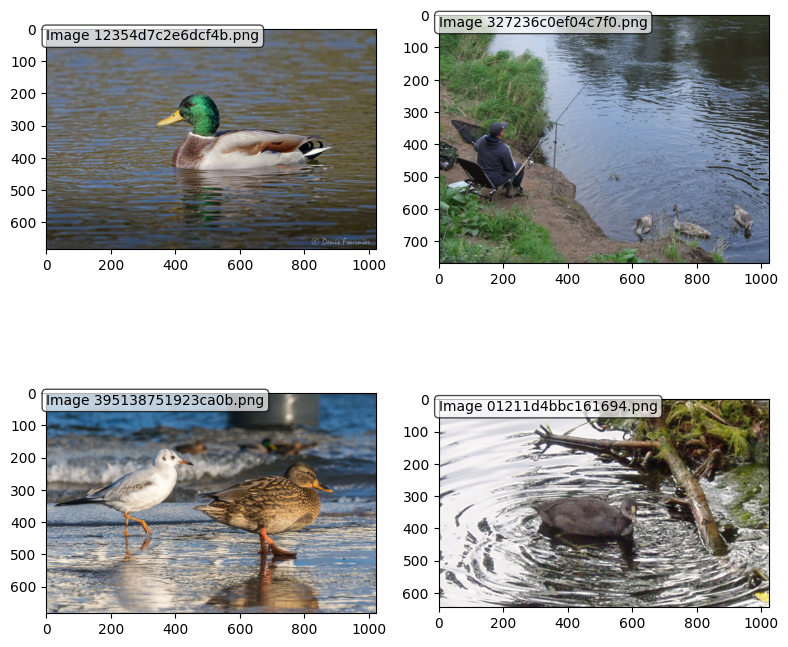

In [46]:
import math
fig, axes = plt.subplots(math.ceil(len(pic_destination)/2), 2, figsize=(8, 8))

# Flatten the axes for easier iteration
axes_flat = axes.flatten()

# Display each image on a subplot
for ax, image, i in zip(axes_flat , pic_destination, range(len(pic_destination))):
  ii = plt.imread(image)
  ax.imshow(ii)
  
  label_x, label_y = 0.1, 0.9  # Example positions (adjust as needed)
  ax.text(label_x, label_y, f"Image {images_list_to_display[i]}", ha='left', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))  # Add label text with formatting
  
    # ax.axis('off')  # Hide axes for cleaner grid

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

In [47]:
results_vis = model_selected(pic_destination)
print(len(results_vis))

# for results in results_vis

0: 640x640 1 duck, 2.5ms
1: 640x640 2 ducks, 2.5ms
2: 640x640 2 ducks, 2.5ms
3: 640x640 (no detections), 2.5ms
Speed: 2.4ms preprocess, 2.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
4


In [48]:
# Visualize the results
pic_des_bbox= []
for i, r in enumerate(results_vis):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array

    # Save results to disk
    r.save(filename= dest_folder_visualise + '/bbox_' + str(images_list_to_display[i]))
    pic_des_bbox.append(dest_folder_visualise + '/bbox_' + str(images_list_to_display[i]))


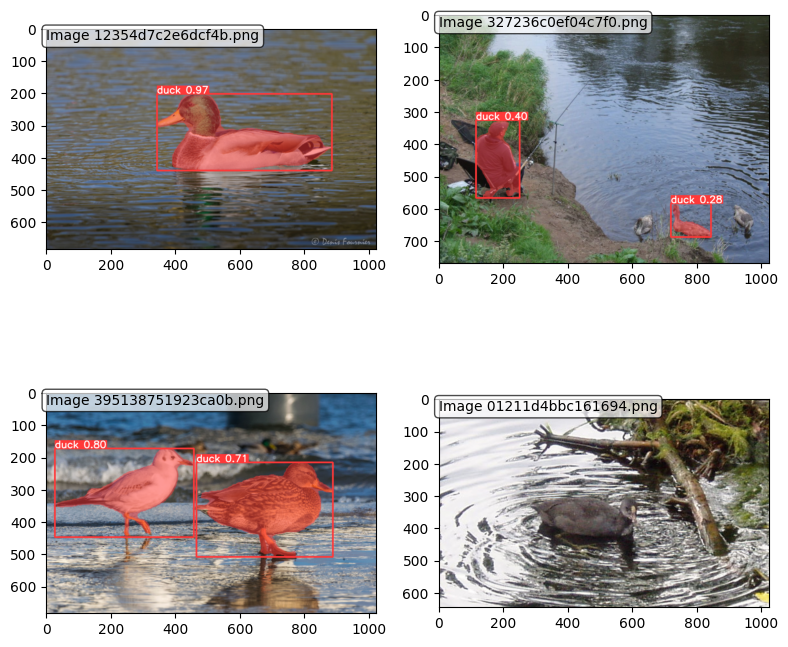

In [49]:
fig, axes = plt.subplots(math.ceil(len(pic_destination)/2), 2, figsize=(8, 8))

# Flatten the axes for easier iteration
axes_flat = axes.flatten()

# Display each image on a subplot
for ax, image, i in zip(axes_flat , pic_des_bbox, range(len(pic_des_bbox))):
  ii = plt.imread(image)
  ax.imshow(ii)
  
  label_x, label_y = 0.1, 0.9  # Example positions (adjust as needed)
  ax.text(label_x, label_y, f"Image {images_list_to_display[i]}", ha='left', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))  # Add label text with formatting
  
    # ax.axis('off')  # Hide axes for cleaner grid

# Adjust layout and display the figure
plt.tight_layout()
plt.show()    

1. It shows totally correct
2. It shows wrong objects detected, with wrong object having more probability than correct one. But both are below usual threshold (0.5), so, none are detected.
3. It shows the same case as 2, and now model predicts the incorrect object (above the usual  threshold of 0.5).
4. It is unable to detect it

The above cases have been mainly selected to show where the model fails

### Augmentation
By checking the output train logs and args.yaml of the model after training, we can see the variable for augment is false, thus not allowing augmentations. The hyperparameters of augmentation, like changing the hue, saturation, orientation, shear .etc. have non-zero values, thus will cause augmentations when augment is True.

The list of augmentations and their purpose as follows:

1. hsv_h : hue control
2. hsv_s : saturation control
3. hsv_v : brightness control
4. degrees: rotation control
5. translate : translation control	
6. scale : scale control
7. shear : shears the image
8. perspective :random perspective transformation to the image, enhancing the model's ability to understand objects in 3D space.
9. flipud : flips the image upside down with the specified probability
10. fliplr : flips the image left to right with the specified probability
11. bgr : flips the image channels from RGB to BGR with the specified probability
12. mosaic : combines four training images into one, simulating different scene compositions and object interactions
13. mixup : blends two images and their labels, creating a composite image
14. copy_paste : copies objects from one image and pastes them onto another
15. auto_augment : automatically applies a predefined augmentation policy (randaugment, autoaugment, augmix)
16. erasing	float: randomly erases a portion of the image during classification training
17. crop_fraction :	crops the classification image to a fraction of its size

All these augmentations are meant to diversify the dataset, increase the spotlight on lesser identified features and improve model's ability to deal with noise.

As for albumentations, I don't  have that library in my environment, so will not be used during augmentation.

In [8]:
model_without_augmentations = YOLO('yolov8n-seg.pt')
model_with_augmentations = YOLO('yolov8n-seg.pt')


In [11]:
index_model = 1
without_augment_result_100_t = model_without_augmentations.train(data=configs_files[0], imgsz=image_size, epochs=epochs_num, name='without_augment_pre_nano_100_t', augment = False)
without_augment_result_100_v = model_without_augmentations.val(data=configs_files[0], imgsz=image_size, name='without_augment_pre_nano_100_v')

Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/scratch/amey.choudhary/Q2_inputs/archive100/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=without_augment_pre_nano_100_t, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

train: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/train.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
val: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/segment/without_augment_pre_nano_100_t/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/without_augment_pre_nano_100_t
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.68G      2.716      4.177      4.382       2.54          4        640: 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         50         52       0.13      0.212     0.0566     0.0126     0.0789      0.115     0.0412    0.00826



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.73G      2.563      3.606      3.907      2.441          5        640: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         50         52      0.318      0.404      0.274     0.0972      0.346      0.212      0.167     0.0484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.62G      1.989      2.877      3.297      2.026          6        640: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         50         52      0.335      0.154      0.167     0.0476      0.376      0.173      0.136     0.0371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.76G      1.823      2.922      3.052      1.873          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         50         52      0.311      0.192      0.136     0.0406      0.339      0.135     0.0909     0.0247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.74G      1.776      2.759      3.226      1.871          3        640: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         50         52      0.447       0.28       0.31      0.109      0.263      0.165      0.109     0.0339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.73G      1.535      2.456      2.825       1.64          5        640: 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         50         52      0.455      0.423      0.312      0.117      0.239      0.231      0.128     0.0322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.74G      1.417       2.39       2.64       1.52          5        640: 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         50         52      0.489      0.462      0.379      0.175      0.419      0.385      0.269      0.099



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.74G      1.397      2.291      2.655        1.5          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

                   all         50         52      0.546      0.481      0.425      0.205      0.419      0.423      0.357      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.74G      1.239      2.215      2.326      1.367          5        640: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         50         52      0.635        0.5      0.475      0.249      0.516      0.442      0.389       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.76G       1.24      2.062      2.387      1.401          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         50         52      0.661      0.481      0.514      0.274      0.606      0.442      0.413      0.243


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.74G       1.22      2.097      2.357       1.41          4        640: 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         50         52      0.623      0.615      0.543      0.302      0.563      0.558      0.446      0.249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.74G     0.9883      1.745      2.018      1.192          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         50         52      0.673      0.577      0.549      0.316      0.559      0.577       0.47      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.63G      1.119      1.756      2.128      1.332          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         50         52       0.61      0.577      0.529      0.292      0.529        0.5      0.424      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.74G     0.9247      1.854      1.916      1.208          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

                   all         50         52      0.517      0.538      0.474      0.278      0.477      0.481      0.413      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.73G     0.9474      1.841      1.885      1.183          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         50         52      0.548      0.489      0.465      0.275      0.548      0.489      0.425      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.74G     0.9958      1.897      1.961      1.222          5        640: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         50         52      0.572      0.481      0.516      0.307      0.572      0.481      0.505      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.74G      1.005      1.745      1.933      1.238          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         50         52       0.55      0.538      0.536      0.329      0.557      0.538      0.522      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.77G     0.9455      1.635      1.887      1.144          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         50         52      0.616      0.615      0.588      0.374      0.616      0.615      0.572       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.76G      1.058      1.854      2.091      1.224          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         50         52      0.617      0.577      0.605      0.395      0.594      0.558      0.581      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.74G     0.9787      1.575      1.822      1.229          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         50         52      0.643      0.596       0.62      0.412      0.605      0.577      0.593       0.36



20 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/without_augment_pre_nano_100_t/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/without_augment_pre_nano_100_t/weights/best.pt, 6.8MB

Validating runs/segment/without_augment_pre_nano_100_t/weights/best.pt...
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


                   all         50         52      0.642      0.596       0.62      0.411      0.605      0.577      0.593      0.359
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/without_augment_pre_nano_100_t
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


                   all         50         52      0.655      0.596      0.621      0.411      0.619      0.625      0.599      0.357
Speed: 0.6ms preprocess, 4.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/without_augment_pre_nano_100_v


In [10]:
index_model = 1
with_augment_result_100_t = model_with_augmentations.train(data=configs_files[0], imgsz=image_size, epochs=epochs_num, name='with_augment_pre_nano_100_t', augment = True, auto_augment='autoaugment')
with_augment_result_100_v = model_with_augmentations.val(data=configs_files[0], imgsz=image_size, name='with_augment_pre_nano_100_v')

Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/scratch/amey.choudhary/Q2_inputs/archive100/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=with_augment_pre_nano_100_t, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False,

train: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/train.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
val: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/segment/with_augment_pre_nano_100_t/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/with_augment_pre_nano_100_t
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20         3G     0.9062      1.395      1.707      1.092          9        640: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

                   all         50         52      0.733      0.712      0.687       0.43      0.668      0.659      0.632      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.79G     0.9506      1.434      1.639      1.068         14        640: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


                   all         50         52      0.682      0.701      0.708      0.452      0.714      0.731      0.719      0.453

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.07G     0.8149      1.318      1.483      1.067          8        640: 100%|██████████| 7/7 [00:01<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         50         52      0.593      0.644      0.592      0.375      0.586      0.625      0.592      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.92G     0.8109      1.186      1.484      1.021         10        640: 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         50         52      0.667      0.653      0.666      0.415      0.627      0.615      0.626      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.08G     0.7469      1.087      1.404     0.9904          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         50         52      0.755      0.533      0.637      0.401      0.689      0.577      0.635      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.96G     0.7271      1.007      1.399          1          6        640: 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         50         52       0.77      0.596      0.613      0.384      0.745      0.577      0.597       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.93G     0.7982      1.245      1.444      1.039          7        640: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         50         52       0.73      0.572      0.638      0.378       0.73      0.572      0.645      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.07G     0.8332       1.19      1.369      1.055         12        640: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

                   all         50         52      0.755      0.577       0.64      0.371      0.766      0.629      0.662      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.93G     0.7507      1.255      1.275      1.003          9        640: 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         50         52       0.67      0.538      0.553      0.337       0.67      0.538      0.554      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.92G      0.871      1.369      1.321      1.056          9        640: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         50         52        0.7      0.462      0.506      0.329       0.64      0.423      0.447      0.247


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.08G     0.7583      1.315      1.786      1.047          4        640: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         50         52      0.453      0.462      0.371      0.175      0.395      0.385      0.262      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.81G     0.8202        1.3      1.796      1.042          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         50         52      0.574      0.385      0.443      0.257      0.632      0.385      0.415      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.81G     0.8041      1.285      1.686      1.114          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         50         52      0.585      0.488       0.53      0.352      0.588      0.481      0.482      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.81G     0.7548       1.25      1.596      1.058          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         50         52      0.657      0.538      0.571      0.365      0.635        0.5      0.529      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.8G     0.8193       1.28      1.526      1.065          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         50         52      0.588      0.538      0.589      0.403      0.588      0.538       0.58      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.81G     0.7725      1.167      1.547      1.073          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         50         52      0.556      0.673      0.578      0.367      0.555      0.654      0.565      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.81G     0.7673      1.022      1.484       1.02          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

                   all         50         52       0.63      0.654      0.635      0.424       0.63      0.654      0.622      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.94G     0.6473      1.038      1.423     0.9663          4        640: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         50         52      0.743      0.635      0.687      0.483       0.72      0.615      0.669      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.06G      0.731      1.036      1.344      1.044          5        640: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

                   all         50         52      0.873      0.596      0.716      0.511      0.856      0.573      0.708      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.81G     0.6433      1.035      1.371      1.007          4        640: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         50         52      0.808      0.648      0.727      0.531      0.784      0.629      0.719      0.522



20 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/with_augment_pre_nano_100_t/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/with_augment_pre_nano_100_t/weights/best.pt, 6.8MB

Validating runs/segment/with_augment_pre_nano_100_t/weights/best.pt...
Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]


TypeError: object of type 'NoneType' has no len()

When doing with augment, it seems to run into some issue and gives message:"object of type 'NoneType' has no len()" . This issue has been raised earlier but not resolved. As it ran for all the epochs and saved the best.pt, we will use that model on validation to check
[Issue Link](https://github.com/ultralytics/ultralytics/issues/7428)

In [13]:
best_pre_nano_100_with_augmentations = YOLO('./runs/segment/with_augment_pre_nano_100_t/weights/best.pt')
result = best_pre_nano_100_with_augmentations.val(data=configs_files[0], imgsz=image_size, name='with_augment_best_pre_nano_100_v')

Ultralytics YOLOv8.1.45 🚀 Python-3.10.13 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /scratch/amey.choudhary/Q2_inputs/archive100/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


                   all         50         52      0.812      0.635      0.724      0.532      0.787      0.615      0.715      0.519
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/with_augment_best_pre_nano_100_v


- Without augmentation, best mAP50 in training is 0.62 and in validation is 0.621
- With augmentation, best mAP50 in training is 0.727 and in validation is 0.724.

There is significant change, due to augmentation bringing out the effects of interactions and highlighting the lesser obvious features, and making model robust to noise.

I believe mosaic as well as erasing float are important augmentations. Mosaic combines different images into one, causing model to learn different types of object interactions and scene compositions. Erasing float causes model to learn about the less obvious features and recognise them.

#### Challenges:

1. Setting up notebook in ADA.
2. Running and understanding yolo.